# Portfolio research agent

* **Parallel aggregator** 
* State updated by 3 finance **Sub-agents**
* The sub-agents will be added to the graph as nodes


### Reference
[Build a personal assistant with subagents](https://docs.langchain.com/oss/python/langchain/multi-agent/subagents-personal-assistant)

### Note:
* Industry research agent uses Tavily for web search. You MUST set the **TAVILY_API_KEY** in the env file for executing the code
* Stock subagents use **Yahoo Finance** API for access the latest news and stock trends

## 0. Setup

In [1]:
from dotenv import load_dotenv
import json
from pydantic import BaseModel, Field, confloat

from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langchain.chat_models import init_chat_model
from langchain.tools import tool
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, END

# Import the prebuilt agents
import finance.stock_research_agent as stock_research
import finance.industry_research_agent as industry_research
import finance.stock_trend_analyst as trend_analysis

from typing import List, Literal
from enum import Enum
from pydantic import BaseModel, Field

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
# CHANGE THIS TO POINT TO YOUR OWN FILE
# Load the file that contains the API keys 
load_dotenv('C:\\Users\\raj\\.jupyter\\.env')

# You can change the index in llm creation calls to control which LLM is used by the agents
# NOTE: Some LLM like Llama may not produce structured output
models = [
            {"model":"gpt-4.1-mini", "model_provider":"openai"},
            {"model":"command-r",  "model_provider":"cohere"},
            {"model": "moonshotai/kimi-k2-instruct", "model_provider": "groq"},
            {"model":"claude-3-5-sonnet-latest", "model_provider":"anthropic"},
            {"model": "llama-3.3-70b-versatile", "model_provider": "groq"}
]

## 1. State schema

In [3]:
class DecisionEnum(str, Enum):
    BUY = "BUY"
    HOLD = "HOLD"
    SELL = "SELL"

# The subagents update the specific attributes in the shared state object
class StockResearchState(BaseModel):
    stock_research: str = Field("", description="Updated by stock research agent")
    industry_research: str = Field("", description="Updated by industry research agent")
    stock_trends_research: str = Field("", description="Updated by stocks trend research agent")
    
    ticker: str = Field("", description="Ticker symbol for the stock")
    report: str = Field("", description="Aggregated report on the stock")
    reasons: List[str] = Field([], description="Reasons to support the decision")
    decision: DecisionEnum = Field(None, description="Recommended action for the stock")
    confidence: confloat(ge=0, le=1) = Field(-1.0, description="Confidence in the recommendation")

## 2. Finance sub-agents nodes
**Note:** Python code for the agents is already provided under the subfolder *finance*

#### Stock research agent node

In [4]:
# Model used for the agents
chat_llm = init_chat_model(**models[0])

# Create & wrap stock research agent
stock_research_agent = stock_research.create_stock_research_agent(chat_llm)

def  stock_research_node(state: StockResearchState)->str:

    result = stock_research_agent.invoke({
        "messages": [HumanMessage(content=f"Analyze stock fundamentals and performance for {state.ticker}")]
    })
    
    return {"stock_research": result["messages"][-1].content}
    

# Unit testing
# state = StockResearchState()
# state.ticker='AAPL'
# result = stock_research_node(state)
# print(result)


#### Industry research agent node

In [5]:
# Create and wrap industry research agent
industry_research_agent = industry_research.create_industry_research_agent(chat_llm)

def  industry_research_node(state: StockResearchState)->str:
    
    result = industry_research_agent.invoke({
        "messages": [HumanMessage(content=f"Analyze industry conditions and competitive position for {state.ticker}")]
    })
    
    return {"industry_research": result["messages"][-1].content}

# Unit testing
# state = StockResearchState()
# state.ticker='AAPL'
# result = industry_research_node(state)
# print(result)


#### Stock trend analyst as node

In [6]:
stock_trend_analyst_agent = trend_analysis.create_stock_trend_analyst_agent(chat_llm)

def  stock_trend_analyst_node(state: StockResearchState)->str:
    
    result = stock_trend_analyst_agent.invoke({
        "messages": [HumanMessage(content=f"Analyze technical and market trends for {state.ticker}")]
    })
    
    return {"stock_trends_research": result["messages"][-1].content}

# Unit testing
# state = StockResearchState()
# state.ticker='AAPL'
# result = stock_trend_analyst_node(state)
# print(result)

## 3. Aggregator agent
Uses the research results generated by the 3 subagents to generate the final report along with the BUY/HOLD/SELL decision

In [7]:
AGGREGATOR_PROMPT = """
                    You are a STOCK RESEARCH EXPERT.
                    
                    You will be given three independent research reports about a stock:
                    - stock_research (company fundamentals & performance)
                    - industry_research (sector and competitive context)
                    - stock_trends_research (market and technical signals)
                    
                    Ticker: {ticker}
                    
                    ------------------------------------
                    RESEARCH INPUTS
                    ------------------------------------
                    
                    [Stock Research]
                    {stock_research}
                    
                    [Industry Research]
                    {industry_research}
                    
                    [Stock Trends Research]
                    {stock_trends_research}
                    
                    ------------------------------------
                    YOUR TASK
                    ------------------------------------
                    
                    Synthesize the research into a final investment assessment.
                    
                    You must:
                    1. Write a concise, executive-level stock report.
                    2. Extract the most important reasons supporting your view.
                    3. Choose exactly ONE recommendation: BUY, HOLD, or SELL.
                    4. Assign a confidence score between 0 and 1.
                    
                    ------------------------------------
                    STRICT RULES
                    ------------------------------------
                    
                    - Use ONLY the provided research.
                    - Do NOT invent financial facts.
                    - Resolve conflicts explicitly.
                    - Weigh downside risks more heavily than weak upside signals.
                    - Avoid generic language.
                    
                    ------------------------------------
                    OUTPUT REQUIREMENTS
                    ------------------------------------
                    
                    Only produce values for:
                    - report (string)
                    - reasons (list of strings)
                    - decision (BUY | HOLD | SELL)
                    - confidence (float between 0 and 1)
                    
                    Think like an investment committee chair delivering a final call.
                    """

# Create the agent
# Note: there are no tools provided to the agents
aggregator_agent = create_react_agent(
    model=init_chat_model(**models[0]),
    tools=[],  # no tools — pure synthesis
    name="stock_aggregator_agent",
    prompt=AGGREGATOR_PROMPT,
    response_format=StockResearchState
)



## 4. Aggregator node

In [8]:
def aggregator_node(state: StockResearchState):
    prompt = AGGREGATOR_PROMPT.format(
        stock_research=state.stock_research,
        industry_research=state.industry_research,
        stock_trends_research=state.stock_trends_research,
        ticker=state.ticker
    )

    response = aggregator_agent.invoke({
        "messages": [HumanMessage(content=prompt)]
    })

    content = response["messages"][-1].content

    result = json.loads(content) 


    return {
        "report": result.get("report", ""),
        "reasons": result.get("reasons", []),
        "decision": result.get("decision", None),
        "confidence": result.get("confidence", -1.0),
    }

# 5. Create the Graph with aggregator


https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/#2-create-supervisor-with-langgraph-supervisor

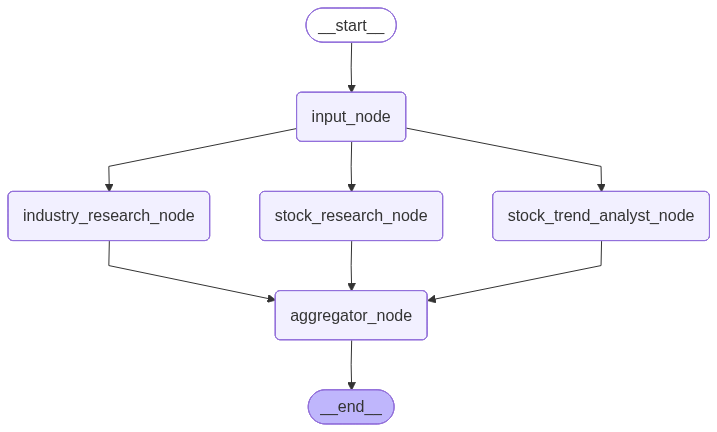

In [9]:

# For future pre-processing
def input_node(StockResearchState):
    # pass
    return {}
    

graph = StateGraph(StockResearchState)

graph.add_node("input_node", input_node)
graph.add_node("stock_research_node", stock_research_node)
graph.add_node("industry_research_node", industry_research_node)
graph.add_node("stock_trend_analyst_node", stock_trend_analyst_node)
graph.add_node("aggregator_node", aggregator_node)

# Entry point
graph.set_entry_point("input_node")

# ---- fan-out (parallel research) ----
graph.add_edge("input_node", "stock_research_node")
graph.add_edge("input_node", "industry_research_node")
graph.add_edge("input_node", "stock_trend_analyst_node")

# ---- fan-in (aggregation) ----
graph.add_edge("stock_research_node", "aggregator_node")
graph.add_edge("industry_research_node", "aggregator_node")
graph.add_edge("stock_trend_analyst_node", "aggregator_node")

# End
graph.add_edge("aggregator_node", END)

stock_research_app = graph.compile()

stock_research_app


# 6.Test the agent

In [10]:
%%time

input = { "ticker": "AAPL"}

response  = stock_research_app.invoke(input)


response

CPU times: total: 3.72 s
Wall time: 57.7 s


{'stock_research': "Apple Inc. (AAPL) is currently a debt-free company, which is a strong fundamental indicator as it implies Apple has no debt obligations weighing on its finances. The company is facing regulatory scrutiny in India related to antitrust concerns over its App Store policies. This scrutiny introduces some uncertainty as India uses Apple's global revenue to determine potential penalties, a method Apple disputes as unfair. \n\nFrom a fundamentals perspective, being debt-free is a positive sign, indicating strong financial health. However, regulatory challenges, especially in a significant market such as India, could potentially impact Apple's revenue or lead to financial penalties, which might affect its stock performance negatively in the short term.\n\nOverall, while Apple's fundamentals appear solid with no debt, investors should consider the potential risks from ongoing regulatory issues in India when evaluating the stock's near-term performance.",
 'industry_research'